In [75]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import xgboost as xgb

%matplotlib inline

In [2]:
train = pd.read_csv("task_2022/train_data_swc.csv")
test = pd.read_csv("task_2022/test_data_swc.csv")

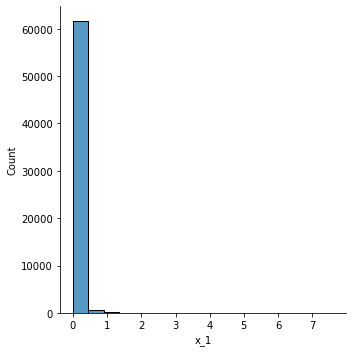

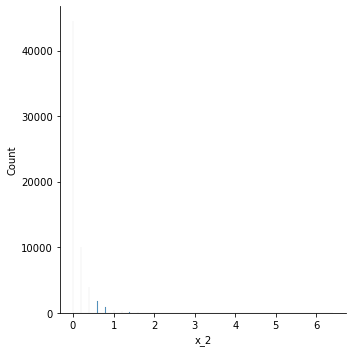

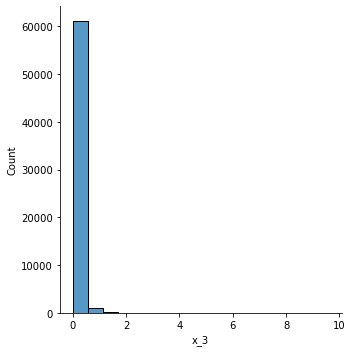

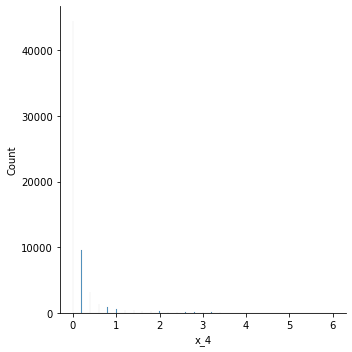

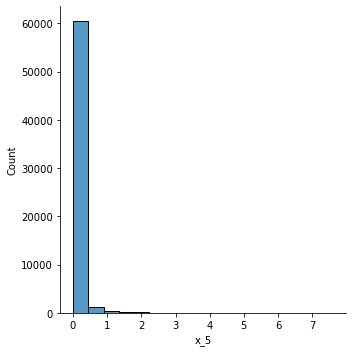

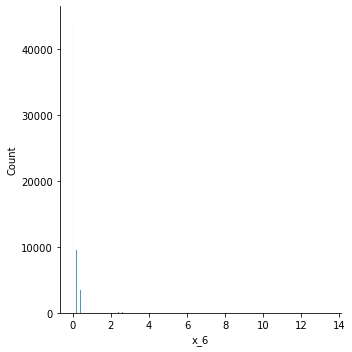

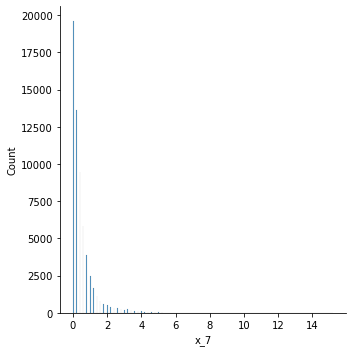

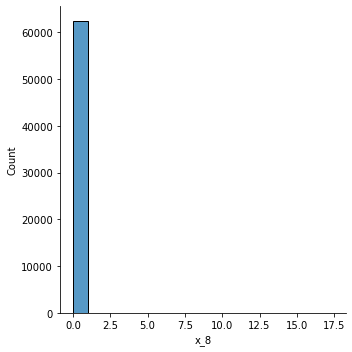

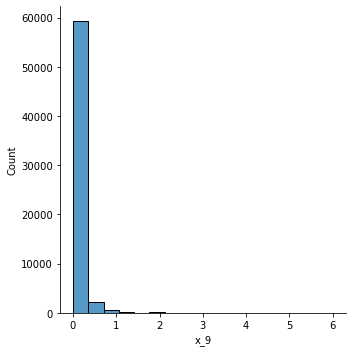

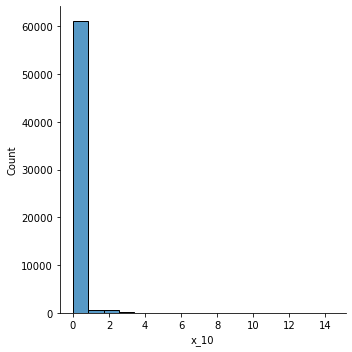

In [ ]:
for i in range(1,11):
    sns.displot(train[f"x_{i}"])
    plt.show()

In [3]:
X_train, y_train = train.drop(["y"], axis=1), train.loc[:, "y"]
X_test = test

print(train.shape, test.shape)

(62500, 109) (150000, 108)


In [6]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(X_tr.shape, X_val.shape)

(46875, 108) (15625, 108)


In [76]:
smote = SMOTE(random_state=42)
X_tr_smote, y_tr_smote = smote.fit_resample(X_tr, y_tr)

In [77]:
lasso = LogisticRegression(random_state=42, penalty='l1', solver='saga').fit(X_tr_smote, y_tr_smote)

/Users/ahmetmelikaksoy/Desktop/swc-classification/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


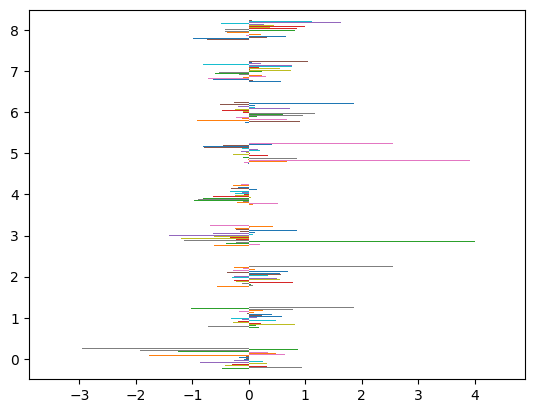

In [78]:
pd.DataFrame(lasso.coef_, columns=X_tr.columns).plot(kind="barh", legend=None)
plt.show()

In [81]:
feat_imps = pd.DataFrame(lasso.coef_, columns=X_tr.columns)

In [82]:
preds = lasso.predict_proba(X_val)

log_loss(y_val, preds)

0.7694598139079223

In [83]:
FIRST_NUMBER_OF_COLS = 50

cols_to_choose = feat_imps.apply(np.abs).sum(axis=0).sort_values(ascending=False)[:FIRST_NUMBER_OF_COLS].index.to_list()

In [84]:
X_tr_el = X_tr_smote[cols_to_choose]
X_val_el = X_val[cols_to_choose]

In [94]:
y_tr_xgb = np.where(y_tr_smote==9, 0, y_tr_smote)
y_val_xgb = np.where(y_val==9, 0, y_val)

In [95]:
clf = xgb.XGBClassifier()

In [96]:
clf.fit(X_tr_el.values, y_tr_xgb)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [97]:
preds_xgb = clf.predict_proba(X_val_el)

log_loss(y_val_xgb, preds_xgb)

0.5639322191875628

In [99]:
from sklearn.ensemble import RandomForestClassifier
import optuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'max_depth' : trial.suggest_int('max_depth', 4, 100),
        'min_samples_split' : trial.suggest_int('min_samples_split', 1, 4),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 4),
        # 'max_features': trial.suggest_categorical('max_features' ,['auto', 'sqrt'])
    }

    clf = RandomForestClassifier(random_state=42, **params).fit(X_tr_el, y_tr_smote)
    pred_probas = clf.predict_proba(X_val_el)
    score = log_loss(y_val, pred_probas)
    return score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

[I 2022-12-26 00:54:02,925] A new study created in memory with name: no-name-3d1bc5f4-7921-43e8-8e9c-e3aed1cc0dec
[I 2022-12-26 00:56:07,835] Trial 0 finished with value: 0.644826119599921 and parameters: {'n_estimators': 576, 'max_depth': 89, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.644826119599921.
[I 2022-12-26 00:56:42,050] Trial 1 finished with value: 0.6449942726554865 and parameters: {'n_estimators': 168, 'max_depth': 43, 'min_samples_split': 1, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.644826119599921.
[I 2022-12-26 00:58:39,979] Trial 2 finished with value: 0.6378263972689545 and parameters: {'n_estimators': 586, 'max_depth': 68, 'min_samples_split': 1, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.6378263972689545.
[I 2022-12-26 01:01:49,184] Trial 3 finished with value: 0.6370166130816447 and parameters: {'n_estimators': 953, 'max_depth': 89, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 3 with value: 0

In [100]:
study.best_params

{'n_estimators': 367,
 'max_depth': 90,
 'min_samples_split': 2,
 'min_samples_leaf': 2}

In [103]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'max_depth' : trial.suggest_int('max_depth', 4, 100),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 10),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5, 1),
        'reg_alpha' : trial.suggest_int('reg_alpha', 40, 180),
        'reg_lambda' : trial.suggest_float('reg_lambda', 0,1),
        # 'max_features': trial.suggest_categorical('max_features' ,['auto', 'sqrt'])
    }

    clf = xgb.XGBClassifier(random_state=42, **params).fit(X_tr_el, y_tr_xgb)
    pred_probas = clf.predict_proba(X_val_el)
    score = log_loss(y_val_xgb, pred_probas)
    return score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2022-12-26 01:21:52,242] A new study created in memory with name: no-name-7aa4c3dd-fe97-4920-b99e-cd446bd1b129
[I 2022-12-26 01:22:05,925] Trial 0 finished with value: 0.7998905081552812 and parameters: {'n_estimators': 18, 'max_depth': 33, 'min_child_weight': 10, 'colsample_bytree': 0.5591702289328935, 'reg_alpha': 161, 'reg_lambda': 0.894406636750108}. Best is trial 0 with value: 0.7998905081552812.
[I 2022-12-26 01:22:26,825] Trial 1 finished with value: 0.7387880505116007 and parameters: {'n_estimators': 25, 'max_depth': 71, 'min_child_weight': 8, 'colsample_bytree': 0.5893261819502291, 'reg_alpha': 162, 'reg_lambda': 0.5020566567105412}. Best is trial 1 with value: 0.7387880505116007.
[I 2022-12-26 01:23:44,160] Trial 2 finished with value: 0.6410290332664861 and parameters: {'n_estimators': 373, 'max_depth': 74, 'min_child_weight': 9, 'colsample_bytree': 0.5243017039229924, 'reg_alpha': 108, 'reg_lambda': 0.3400503737613697}. Best is trial 2 with value: 0.6410290332664861.
[I 

KeyboardInterrupt: 

In [101]:
study.best_params

{'n_estimators': 367,
 'max_depth': 90,
 'min_samples_split': 2,
 'min_samples_leaf': 2}